Using only middle frame

In [1]:
import pandas as pd
import numpy as np
import os

In [2]:
# dataset directory
root_dir = r'/mnt/g/textures/texture recognition/gelsight dataset'

In [3]:
# dataframe with name of videos
training_data = pd.DataFrame()
videos = []
tags = os.listdir(root_dir)

for dir in os.listdir(root_dir):
    folder_path = os.path.join(root_dir, dir)

    for vid_files in os.listdir(folder_path):
        videos.append(vid_files)

training_data['videos'] = videos
print(tags)

['S007', 'S029', 'S032', 'S033', 'S045', 'S064', 'S093', 'S094', 'S097', 'S100']


## Dataset preparing

In [4]:
import torch
from torch.utils.data import Dataset, DataLoader
from PIL import Image
from torchvision import transforms
import cv2

In [5]:
from PIL import Image

class VideoDataset(Dataset):
    ''' 
        A dataset class for handling pressure sensor data from GIF files.
            Args:
        - root_dir (str): Root directory where the dataset is stored.
        - tags (list): List of labels corresponding to each sample.
    
        Note: 
        ['S005' -> 0 , 'S007' -> 1, 'S008' -> 2, 'S010'-> 3, 'S011'-> 4, 
        'S014'-> 5, 'S016'-> 6, 'S044'-> 7, 'S054'-> 8, 'S055'-> 9]
        
        Dataset = (frames, label)
        number of frames vary for each dataset

    '''
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.classes = os.listdir(root_dir)
        self.video_paths = []
        self.labels = []

        for label, class_name in enumerate(self.classes):
            class_dir = os.path.join(root_dir, class_name)
            videos = os.listdir(class_dir)
            for video in videos:
                if video.endswith('.avi'):
                    video_path = os.path.join(class_dir, video)
                    self.video_paths.append(video_path)
                    self.labels.append(label)
    
    def __len__(self):
        return len(self.video_paths)
    
    def __getitem__(self, idx):
        video_path = self.video_paths[idx]
        frame = self.extract_middle_frame(video_path)
        
        if self.transform:
            frame = self.transform(frame)
        
        frame_tensor = torch.tensor(np.array(frame))
        label = self.labels[idx]
        return frame_tensor, label
    
    def extract_middle_frame(self, video_path):
        cap = cv2.VideoCapture(video_path)
        if not cap.isOpened():
            raise ValueError(f"Error opening video file {video_path}")
        
        num_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
        middle_frame_idx = num_frames // 2
        cap.set(cv2.CAP_PROP_POS_FRAMES, middle_frame_idx)
        
        ret, frame = cap.read()
        cap.release()
        
        if not ret:
            raise ValueError(f"Error reading frame from video file {video_path}")
        
        frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        frame_pil = Image.fromarray(frame_rgb)
        
        return frame_pil




In [6]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
])

dataset = VideoDataset(root_dir, transform=transform)

In [7]:
a,b = dataset[25]
a.size()

torch.Size([3, 224, 224])

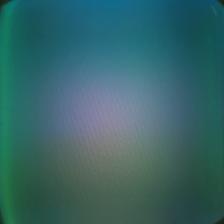

In [8]:
# checking dataset prepared

import torch
from PIL import Image
import torchvision.transforms as transforms


def visualize_frame_pil(frame_tensor):
 
    transform = transforms.ToPILImage()
    frame_pil = transform(frame_tensor)
    frame_pil.show()


visualize_frame_pil(a)


# CNN + LSTM model

In [9]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torchvision.models import resnet18
from tqdm import tqdm

In [10]:
class CNN_LSTM(nn.Module):
    
    def __init__(self, num_classes):
        super(CNN_LSTM, self).__init__()
        
        self.cnn = nn.Sequential(nn.Conv2d(in_channels=3, out_channels= 32, kernel_size= 3, stride = 1, padding= 1),
                                 nn.ReLU(), 
                                 nn.MaxPool2d(kernel_size= 2, stride= 2),
                                 nn.Conv2d(in_channels= 32, out_channels= 64, kernel_size= 3, stride= 1, padding= 1),
                                 nn.ReLU(),
                                 nn.MaxPool2d(kernel_size= 2, stride= 2))
        
        
        
        self.lstm = nn.LSTM(input_size= self.cnn_output_size, hidden_size= 512, num_layers= 1, batch_first= True)
        
    def forward(self, frames):
        batch_size, T, C, H, W = frames.size()
        
        frames = frames.view(batch_size*T, C, H, W)
        cnn_features = self.cnn(frames)
        
        cnn_features = cnn_features.view(batch_size, T, -1)
        
        lstm_output, _ = self.lstm(cnn_features)
        
        features = lstm_output[:, -1, :]
        
        return features
    
    def calc_output_size(self):
        dummy_input = torch.zeros(1,3,244,244)
        cnn_output = self.cnn(dummy_input)
        return cnn_output.numel()//cnn_output.size(0)
        
                

In [11]:
class CNNLSTM(nn.Module):
    def __init__(self, num_classes):
        super(CNNLSTM, self).__init__()
        self.resnet = resnet18(pretrained=True)
        self.resnet.fc = nn.Sequential(nn.Linear(self.resnet.fc.in_features, 512))
        self.lstm = nn.LSTM(input_size=512, hidden_size=256, num_layers=3)
        self.fc = nn.Linear(256, num_classes)
       
    def forward(self, frame):

        x = self.resnet(frame) 
        x = x.unsqueeze(0) 
        out, (h_n, c_n) = self.lstm(x)  
        lstm_out = h_n[-1]  

        return lstm_out


In [12]:
model = CNNLSTM(10)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

/home/admins/miniconda3/envs/myenv/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/admins/miniconda3/envs/myenv/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


CNNLSTM(
  (resnet): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_runn

In [13]:
model.eval()

feature_vectors = []
labels = []

with torch.no_grad(), tqdm(total=len(dataset), desc='Extracting Features', unit='sample') as pbar:
    for frames, label in dataset:
        frames = frames.to(device)
        
        lstm_out = model(frames.unsqueeze(0))
        
        feature_vectors.append(lstm_out.squeeze().cpu().numpy())
        labels.append(label)
        pbar.update(1)


feature_vectors = np.array(feature_vectors)
labels = np.array(labels)

Extracting Features:   0%|          | 0/200 [00:00<?, ?sample/s]

Extracting Features: 100%|██████████| 200/200 [00:10<00:00, 18.45sample/s]


Dim-Red using UMAP 

In [14]:
new_labels = []
for i in range(len(labels)):
    new_labels.append(str(tags[labels[i]]))
    
print(new_labels)

['S007', 'S007', 'S007', 'S007', 'S007', 'S007', 'S007', 'S007', 'S007', 'S007', 'S007', 'S007', 'S007', 'S007', 'S007', 'S007', 'S007', 'S007', 'S007', 'S007', 'S029', 'S029', 'S029', 'S029', 'S029', 'S029', 'S029', 'S029', 'S029', 'S029', 'S029', 'S029', 'S029', 'S029', 'S029', 'S029', 'S029', 'S029', 'S029', 'S029', 'S032', 'S032', 'S032', 'S032', 'S032', 'S032', 'S032', 'S032', 'S032', 'S032', 'S032', 'S032', 'S032', 'S032', 'S032', 'S032', 'S032', 'S032', 'S032', 'S032', 'S033', 'S033', 'S033', 'S033', 'S033', 'S033', 'S033', 'S033', 'S033', 'S033', 'S033', 'S033', 'S033', 'S033', 'S033', 'S033', 'S033', 'S033', 'S033', 'S033', 'S045', 'S045', 'S045', 'S045', 'S045', 'S045', 'S045', 'S045', 'S045', 'S045', 'S045', 'S045', 'S045', 'S045', 'S045', 'S045', 'S045', 'S045', 'S045', 'S045', 'S064', 'S064', 'S064', 'S064', 'S064', 'S064', 'S064', 'S064', 'S064', 'S064', 'S064', 'S064', 'S064', 'S064', 'S064', 'S064', 'S064', 'S064', 'S064', 'S064', 'S093', 'S093', 'S093', 'S093', 'S093',

In [15]:
import matplotlib.pyplot as plt
from umap import UMAP
from sklearn.preprocessing import StandardScaler
import seaborn as sns


2024-09-08 23:17:47.655485: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-09-08 23:17:47.720637: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-09-08 23:17:47.739351: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-09-08 23:17:47.871267: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-09-08 23:17:48.957306: W tensorflow/compiler/tf2

/home/admins/miniconda3/envs/myenv/lib/python3.9/site-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


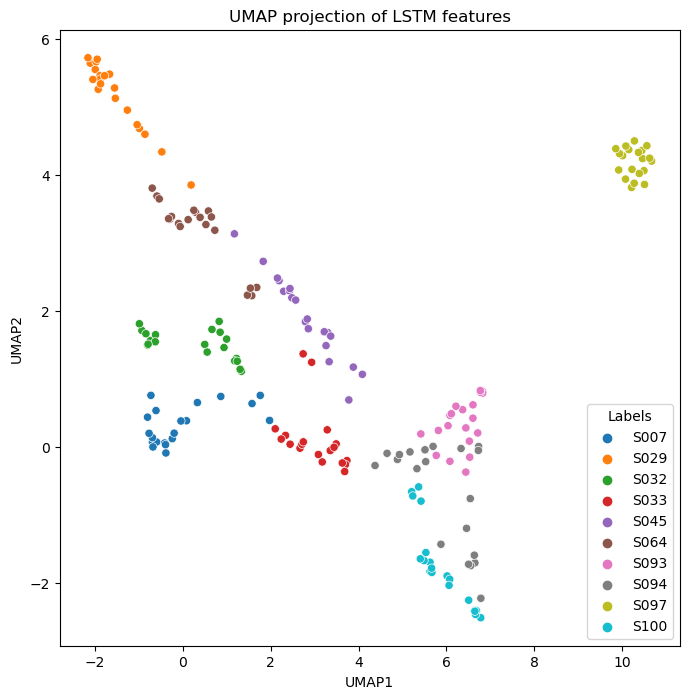

In [16]:
scaler = StandardScaler()
scaled_features = scaler.fit_transform(feature_vectors)

umap = UMAP(n_components=2, random_state=150)
umap_features = umap.fit_transform(scaled_features)

plt.figure(figsize=(8, 8))
sns.scatterplot(x=umap_features[:, 0], y=umap_features[:, 1], hue=new_labels, palette='tab10')
plt.title('UMAP projection of LSTM features')
plt.xlabel('UMAP1')
plt.ylabel('UMAP2')
plt.legend(title='Labels')
plt.show()


/home/admins/miniconda3/envs/myenv/lib/python3.9/site-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


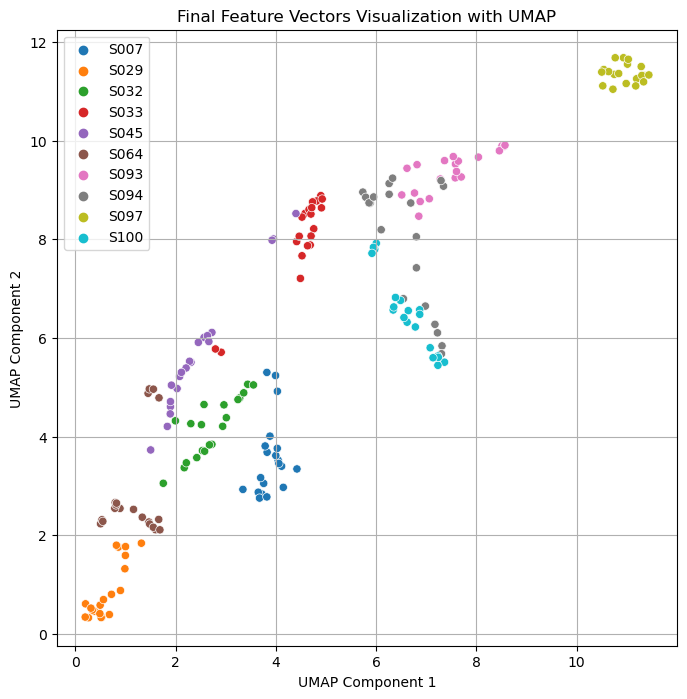

In [60]:
umap2 = UMAP(n_components=2,random_state=52)

new_features = umap2.fit_transform(feature_vectors)

plt.figure(figsize=(8, 8))
sns.scatterplot(x=new_features[:, 0], y=new_features[:, 1], hue=new_labels, palette='tab10')
plt.title('Final Feature Vectors Visualization with UMAP')
plt.xlabel('UMAP Component 1')
plt.ylabel('UMAP Component 2')
plt.grid(True)
plt.show()




T-SNE

In [44]:
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler

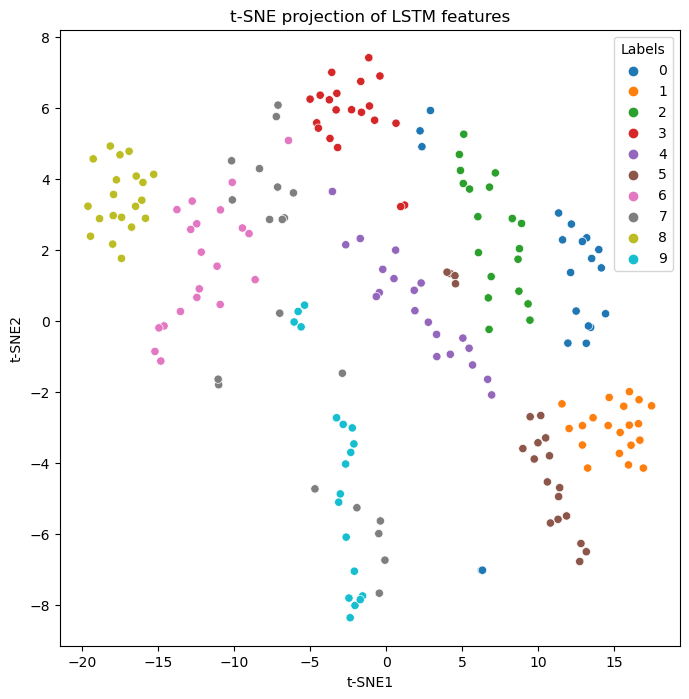

In [45]:
scaler = StandardScaler()
scaled_features = scaler.fit_transform(feature_vectors)

tsne = TSNE(n_components=2, random_state=42)
tsne_features = tsne.fit_transform(scaled_features)

plt.figure(figsize=(8, 8))
sns.scatterplot(x=tsne_features[:, 0], y=tsne_features[:, 1], hue=labels, palette='tab10')
plt.title('t-SNE projection of LSTM features')
plt.xlabel('t-SNE1')
plt.ylabel('t-SNE2')
plt.legend(title='Labels')
plt.show()